In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    return SVG(
        model_to_dot(
            model,
            show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

Using TensorFlow backend.


In [3]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from kerashistoryplot.callbacks import PlotHistory

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [494]:
from sklearn.model_selection import train_test_split

In [631]:
def make_bishop_data(num=1000, sort=True):
    y = np.linspace(0, 1, num=num)
    x = y + 0.3 * np.sin(2 * np.pi * y) + 0.2 * np.random.rand(num) - 0.1
    if sort:
        order = x.argsort()
        x, y = x[order], y[order]
    return x.reshape(-1, 1), y

X_train, y_train = make_bishop_data(num=10000)
X_test, y_test = make_bishop_data(num=10000)

X_plot = np.linspace(min(X_train), max(X_train), num=200).reshape(-1, 1)

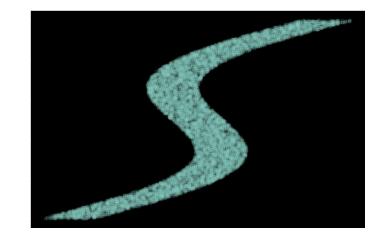

In [633]:
plt.plot(X_train, y_train, '.', alpha=0.1)

In [628]:
import deepquantiles

from deepquantiles.losses import sk_quantile_loss

# Multi-Quantile Regression

In [629]:
regressor = deepquantiles.MultiQuantileRegressor(
    shared_units=(32, 32, 32),
    quantile_units=(64, ),
    quantiles=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99],
    lr=0.01,
    epochs=10,
    batch_size=1000
)

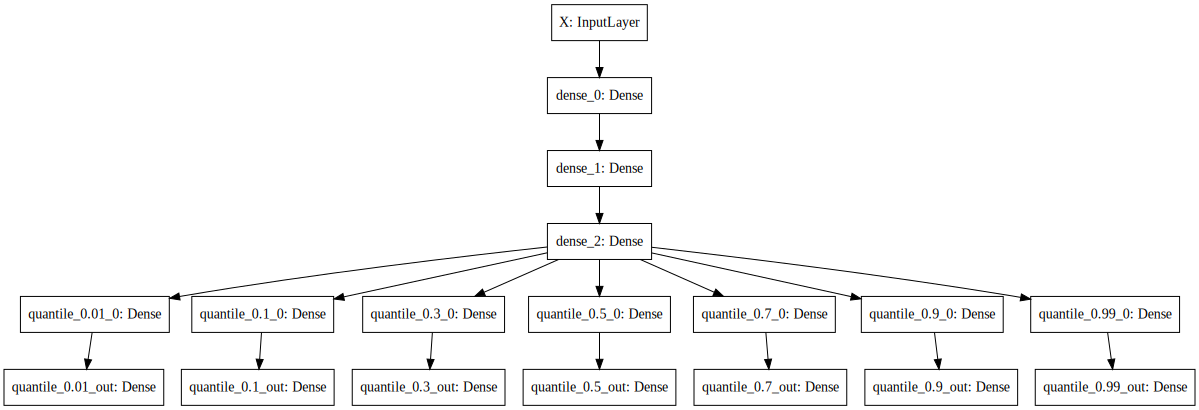

In [630]:
vis_model(regressor.model, show_shapes=False)

In [500]:
regressor.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
dense_0 (Dense)                 (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense_0[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
__________________________________________________________________________________________________
quantile_0

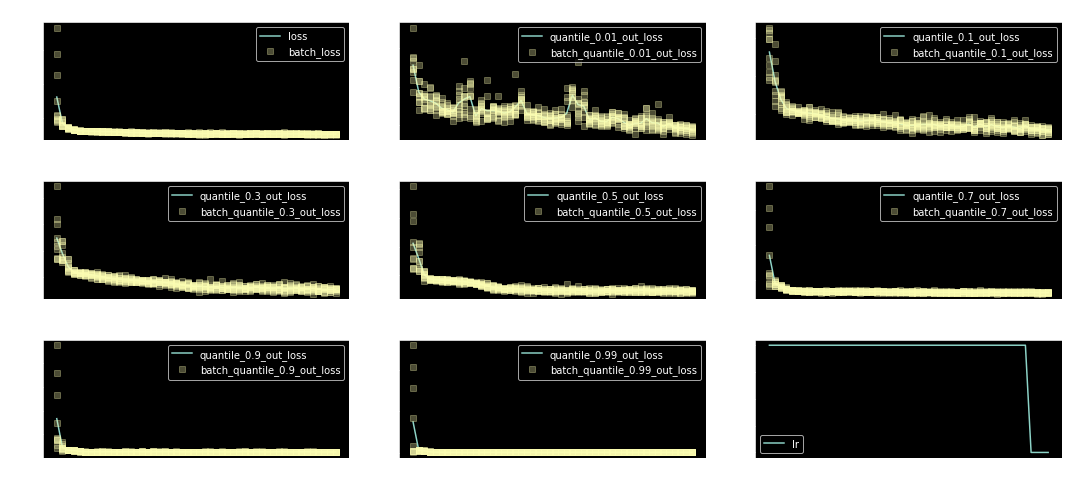

CPU times: user 2min 42s, sys: 19.6 s, total: 3min 2s
Wall time: 1min 36s


In [501]:
%%time
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=30),
    PlotHistory(batches=True, n_cols=3, figsize=(15, 7))
]

regressor.fit(X_train, y_train, epochs=50, batch_size=1000, verbose=1, callbacks=callbacks, shuffle=True)

In [506]:
q_preds = regressor.predict(X_test)

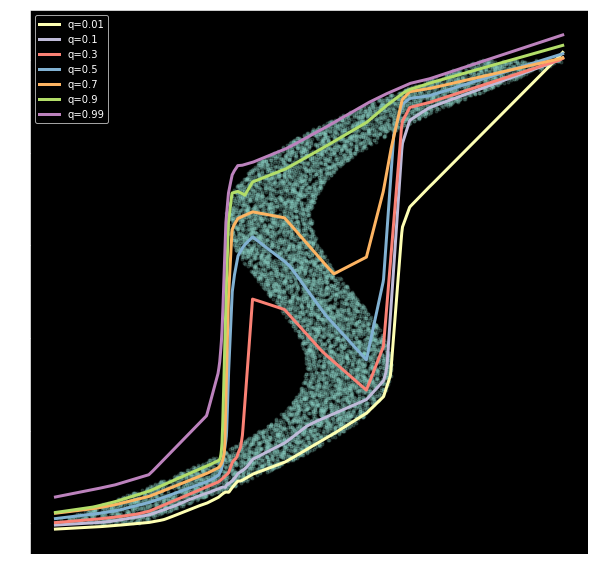

In [507]:
plt.figure(figsize=(10, 10))
plt.plot(X_train, y_train, '.', alpha=0.2)
for q, q_pred in zip(regressor.quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'q={q}')
plt.legend()

(0, 1)

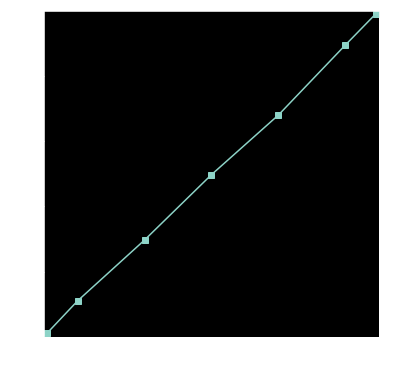

In [509]:
calibrations = [np.mean(y_test < q_pred.ravel()) for q, q_pred in zip(regressor.quantiles, q_preds)]

plt.figure(figsize=(6, 6))
plt.plot(regressor.quantiles, calibrations, 's-')
plt.xlabel('quantile (predicted)')
plt.ylabel('fraction of data')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [554]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(regressor.quantiles, q_preds)]

CPU times: user 5.47 s, sys: 4.04 s, total: 9.5 s
Wall time: 9.52 s


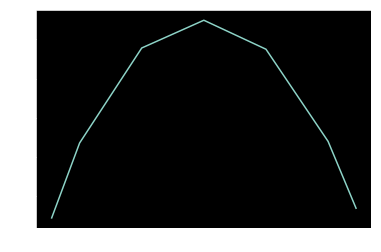

In [555]:
plt.plot(regressor.quantiles, scores)

## Regress on Quantile `q`

In [614]:
regressor = deepquantiles.CDFRegressor(
    hidden_units=(32, 32, 64, 64, 32, 32),
    lr=0.01,
    activation='relu'
)

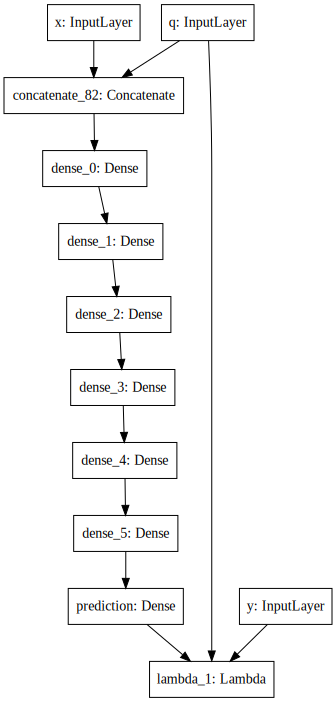

In [615]:
vis_model(regressor.model['loss'])

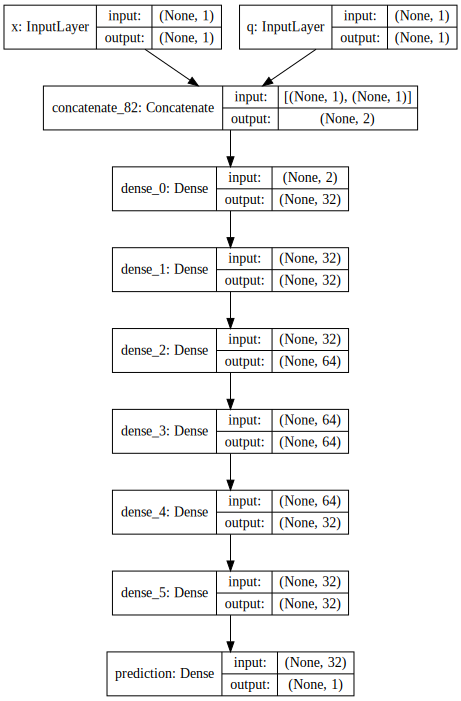

In [616]:
vis_model(regressor.model['quantile'], show_shapes=True)

In [617]:
regressor.model['quantile'].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
q (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_82 (Concatenate)    (None, 2)            0           x[0][0]                          
                                                                 q[0][0]                          
__________________________________________________________________________________________________
dense_0 (Dense)                 (None, 32)           96          concatenate_82[0][0]             
__________

In [618]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=30),
    PlotHistory(batches=False, n_cols=3, figsize=(15, 7))
]

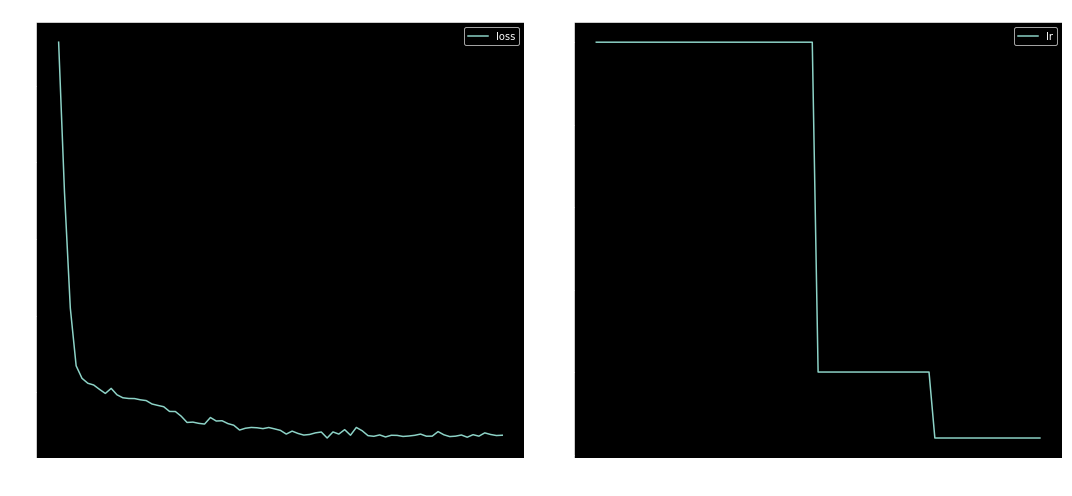

CPU times: user 1min 40s, sys: 13 s, total: 1min 53s
Wall time: 58.3 s


In [619]:
%%time
regressor.fit(X_train, y_train, epochs=100, batch_size=1000, verbose=1, callbacks=callbacks,
              q_mode='point', shuffle=True, shuffle_points=True)

In [620]:
quantiles = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
q_preds = []
scores = []
for q in tqdm(quantiles):
    q_test = 0 * X_test + q
    q_pred = regressor.predict(X_test, q_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

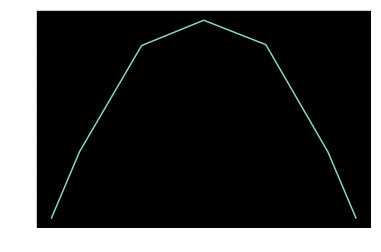

In [621]:
plt.plot(quantiles, scores)

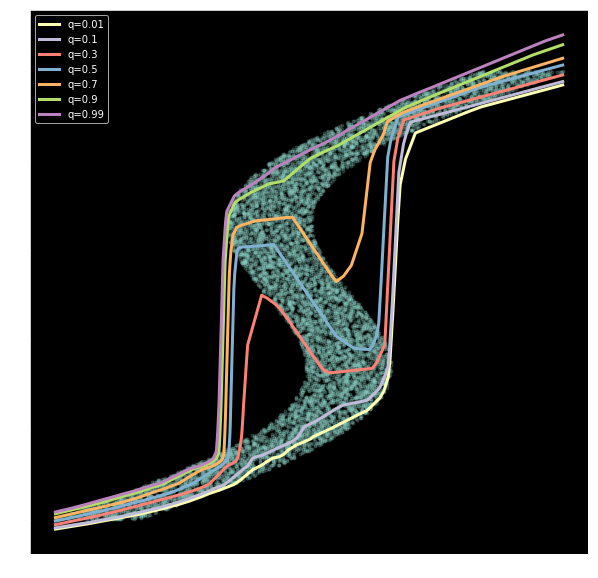

In [622]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, '.', alpha=0.2)
for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'q={q}')
plt.legend()

## Gradient Boosting QR

In [598]:
from sklearn.ensemble import GradientBoostingRegressor

In [599]:
gbr = GradientBoostingRegressor(
    loss='quantile',
#     alpha=0.5,
#     n_estimators=250,
#     max_depth=3,
#     learning_rate=.1,
#     min_samples_leaf=9,
#     min_samples_split=9,
#     warm_start=False
)

In [600]:
%%time
quantiles = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
q_preds = []
scores = []
for q in quantiles:
    gbr.set_params(alpha=q)
    gbr.fit(X_train, y_train)
    q_pred = gbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

CPU times: user 1.87 s, sys: 7.74 ms, total: 1.87 s
Wall time: 1.89 s


In [601]:
%%time
sk_quantile_loss(q, y_test, q_pred)

CPU times: user 122 µs, sys: 16 µs, total: 138 µs
Wall time: 129 µs


0.003419253295651769

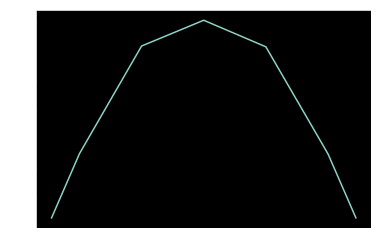

In [602]:
plt.plot(quantiles, scores)

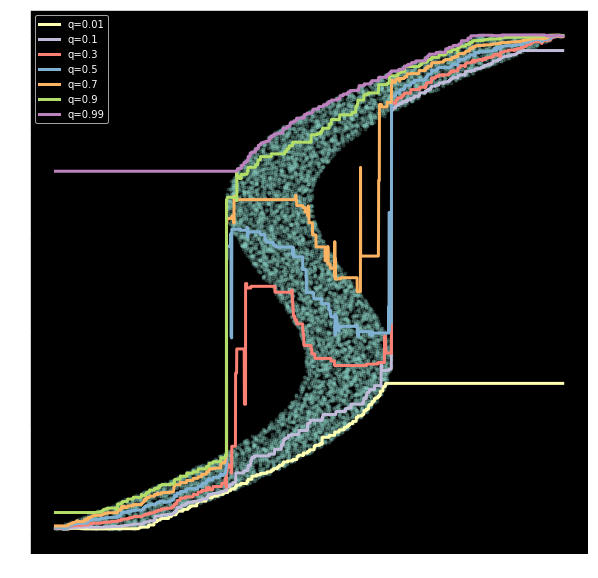

In [603]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, '.', alpha=0.2)
for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'q={q}')
plt.legend()

## CatBoost

In [472]:
from catboost import CatBoostRegressor
from tqdm.autonotebook import tqdm

In [473]:
cbr = CatBoostRegressor(verbose=0)

In [474]:
quantiles = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
q_preds = []
scores = []
for q in tqdm(quantiles):
    cbr.set_params(loss_function=f'Quantile:alpha={q}')
    cbr.fit(X_train, y_train)
    q_pred = cbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_train, cbr.predict(X_train)))

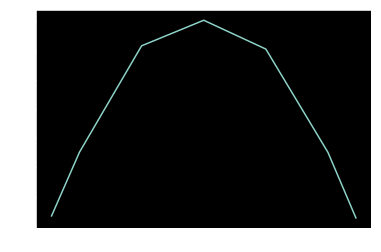

In [475]:
plt.plot(quantiles, scores)

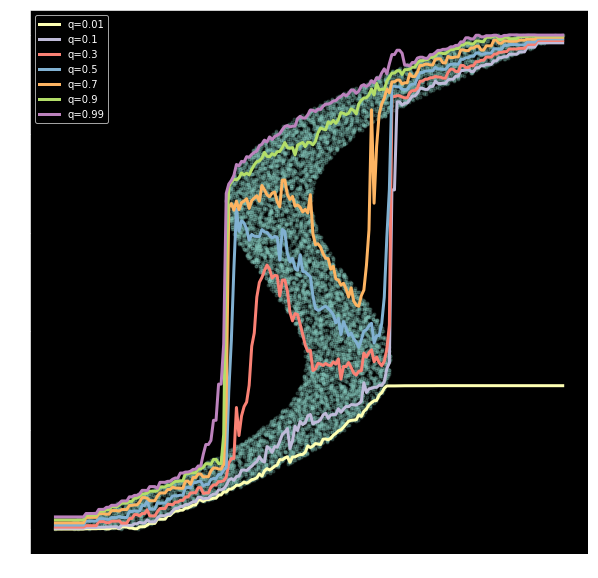

In [476]:
plt.figure(figsize=(10, 10))
plt.plot(X_train, y_train, '.', alpha=0.2)
for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'q={q}')
plt.legend()